# Building GPT on Text Data and Generating New Text

This notebook demonstrates how to train a Generative Pre-trained Transformer (GPT) model on text data and use it to generate new text. Below is an explanation of the code involved, along with properly formatted Markdown for Jupyter Notebooks.

In [3]:
import pandas as pd

with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print("length of dataset in characters: ", len(text))

print('\n')
# first 100 Chars
print("first 200 chars are : \n", text[:200])

length of dataset in characters:  1115394


first 200 chars are : 
 First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


## Creating Character Vocabulary
- `chars`: Extracts all unique characters from the dataset and sorts them.
- `vocab_size`: The total number of unique characters, which determines the vocabulary size.

In [4]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("Characters present in the dataset are", ''.join(chars))
print("Vocab size is :", vocab_size)

Characters present in the dataset are 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Vocab size is : 65


## Creating Encoding and Decoding Functions

- `stoi` (String to Index): Maps each character to a unique index.
- `itos` (Index to String): Maps each index back to its corresponding character.
- `encode`: Converts a string into a list of integer indices based on the vocabulary.
- `decode`: Converts a list of indices back into the original string.

In [5]:
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

### Example

In [6]:
encode("Vinay Vaida")

[34, 47, 52, 39, 63, 1, 34, 39, 47, 42, 39]

In [7]:
decode([34, 47, 52, 39, 63, 1, 34, 39, 47, 42, 39])

'Vinay Vaida'

## Converting Input data to torch tensor to train the model

In [8]:
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

## Splitting Dataset into Train and Validation split

- **Train/Validation Split**: 90% of the data is used for training, and 10% for validation.


In [9]:
# splitting data set into train and validation
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

## Creating Input–Output Pairs for Training

- To train the model, we prepare the data by creating input–output pairs from text.
- For each position in a sequence, the input is a series of characters up to that point (called the **context**),
- the target is the **next character**. This way, the model learns to predict the next token based on previous ones.
- By shifting the input sequence by one position to form the target, we build the dataset needed for training an autoregressive language model.


In [10]:
block_size = 8
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


## Encoding Output to Strings for Clarity

If we decode the above numeric token outputs back into strings, it's easier to understand what the model is generating.

The entire output sequence represents **one batch of input** given to the model for prediction or generation.


In [11]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {decode(context.tolist())} the target: {itos[target.tolist()]}")

when input is F the target: i
when input is Fi the target: r
when input is Fir the target: s
when input is Firs the target: t
when input is First the target:  
when input is First  the target: C
when input is First C the target: i
when input is First Ci the target: t


## Understanding B, T, C

- **B (Batch Size)**: Number of sequences processed in parallel during training.
- **T (Time or Block Size)**: Number of tokens in each input sequence (the context length).
- **C (Channels or Vocab Size)**: Number of possible output classes (unique characters).

- `torch.manual_seed(1337)`: Ensures reproducibility by fixing the random seed.

In [12]:
torch.manual_seed(1337)
batch_size = 4 # also called as B
block_size = 8 # aslo called as Time(T)

In [13]:
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb)
print('targets:')
print(yb)
print('----')


for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is '{context}' the target: '{target}'")

## Converting Inputs and Targets to Plain Text
for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is '{decode(context.tolist())}' the target: '{itos[target.tolist()]}'")

inputs:
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is 'tensor([24])' the target: '43'
when input is 'tensor([24, 43])' the target: '58'
when input is 'tensor([24, 43, 58])' the target: '5'
when input is 'tensor([24, 43, 58,  5])' the target: '57'
when input is 'tensor([24, 43, 58,  5, 57])' the target: '1'
when input is 'tensor([24, 43, 58,  5, 57,  1])' the target: '46'
when input is 'tensor([24, 43, 58,  5, 57,  1, 46])' the target: '43'
when input is 'tensor([24, 43, 58,  5, 57,  1, 46, 43])' the target: '39'
when input is 'tensor([44])' the target: '53'
when input is 'tensor([44, 53])' the target: '56'
when input is 'tensor([44, 53, 56])' the target: '1'
when input is

In [14]:
print(xb) # our input to the transformer

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


In [15]:
print(yb) #our o/p to transformer

tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])


## Bigram Language Model

In [16]:
import torch
import pandas as pd
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers
        print(self.token_embedding_table(idx))
        logits = self.token_embedding_table(idx) # (B,T,C) where Batch size(B) = 4, Time(T) = 8, Channels(C) = vocab size

        B, T, C = logits.shape
        logits = logits.view(B*T, C)
        targets = targets.view(B*T)
        loss = F.cross_entropy(logits, targets)
        return logits,loss

m = BigramLanguageModel(vocab_size)
logits, loss =  m(xb, yb)
print(logits, logits.shape)

tensor([[[-1.5101, -0.0948,  1.0927,  ..., -0.6126, -0.6597,  0.7624],
         [ 0.3323, -0.0872, -0.7470,  ..., -0.6716, -0.9572, -0.9594],
         [ 0.2475, -0.6349, -1.2909,  ...,  1.3064, -0.2256, -1.8305],
         ...,
         [ 0.5978, -0.0514, -0.0646,  ..., -1.4649, -2.0555,  1.8275],
         [ 1.0901,  0.2170, -2.9996,  ..., -0.5472, -0.8017,  0.7761],
         [ 0.3323, -0.0872, -0.7470,  ..., -0.6716, -0.9572, -0.9594]],

        [[ 1.0541,  1.5018, -0.5266,  ...,  1.8574,  1.5249,  1.3035],
         [-0.1324, -0.5489,  0.1024,  ..., -0.8599, -1.6050, -0.6985],
         [-0.6722,  0.2322, -0.1632,  ...,  0.1390,  0.7560,  0.4296],
         ...,
         [ 1.0901,  0.2170, -2.9996,  ..., -0.5472, -0.8017,  0.7761],
         [ 1.1513,  1.0539,  3.4105,  ..., -0.5686,  0.9079, -0.1701],
         [ 0.2475, -0.6349, -1.2909,  ...,  1.3064, -0.2256, -1.8305]],

        [[-0.2103,  0.4481,  1.2381,  ...,  1.3597, -0.0821,  0.3909],
         [ 0.2475, -0.6349, -1.2909,  ...,  1

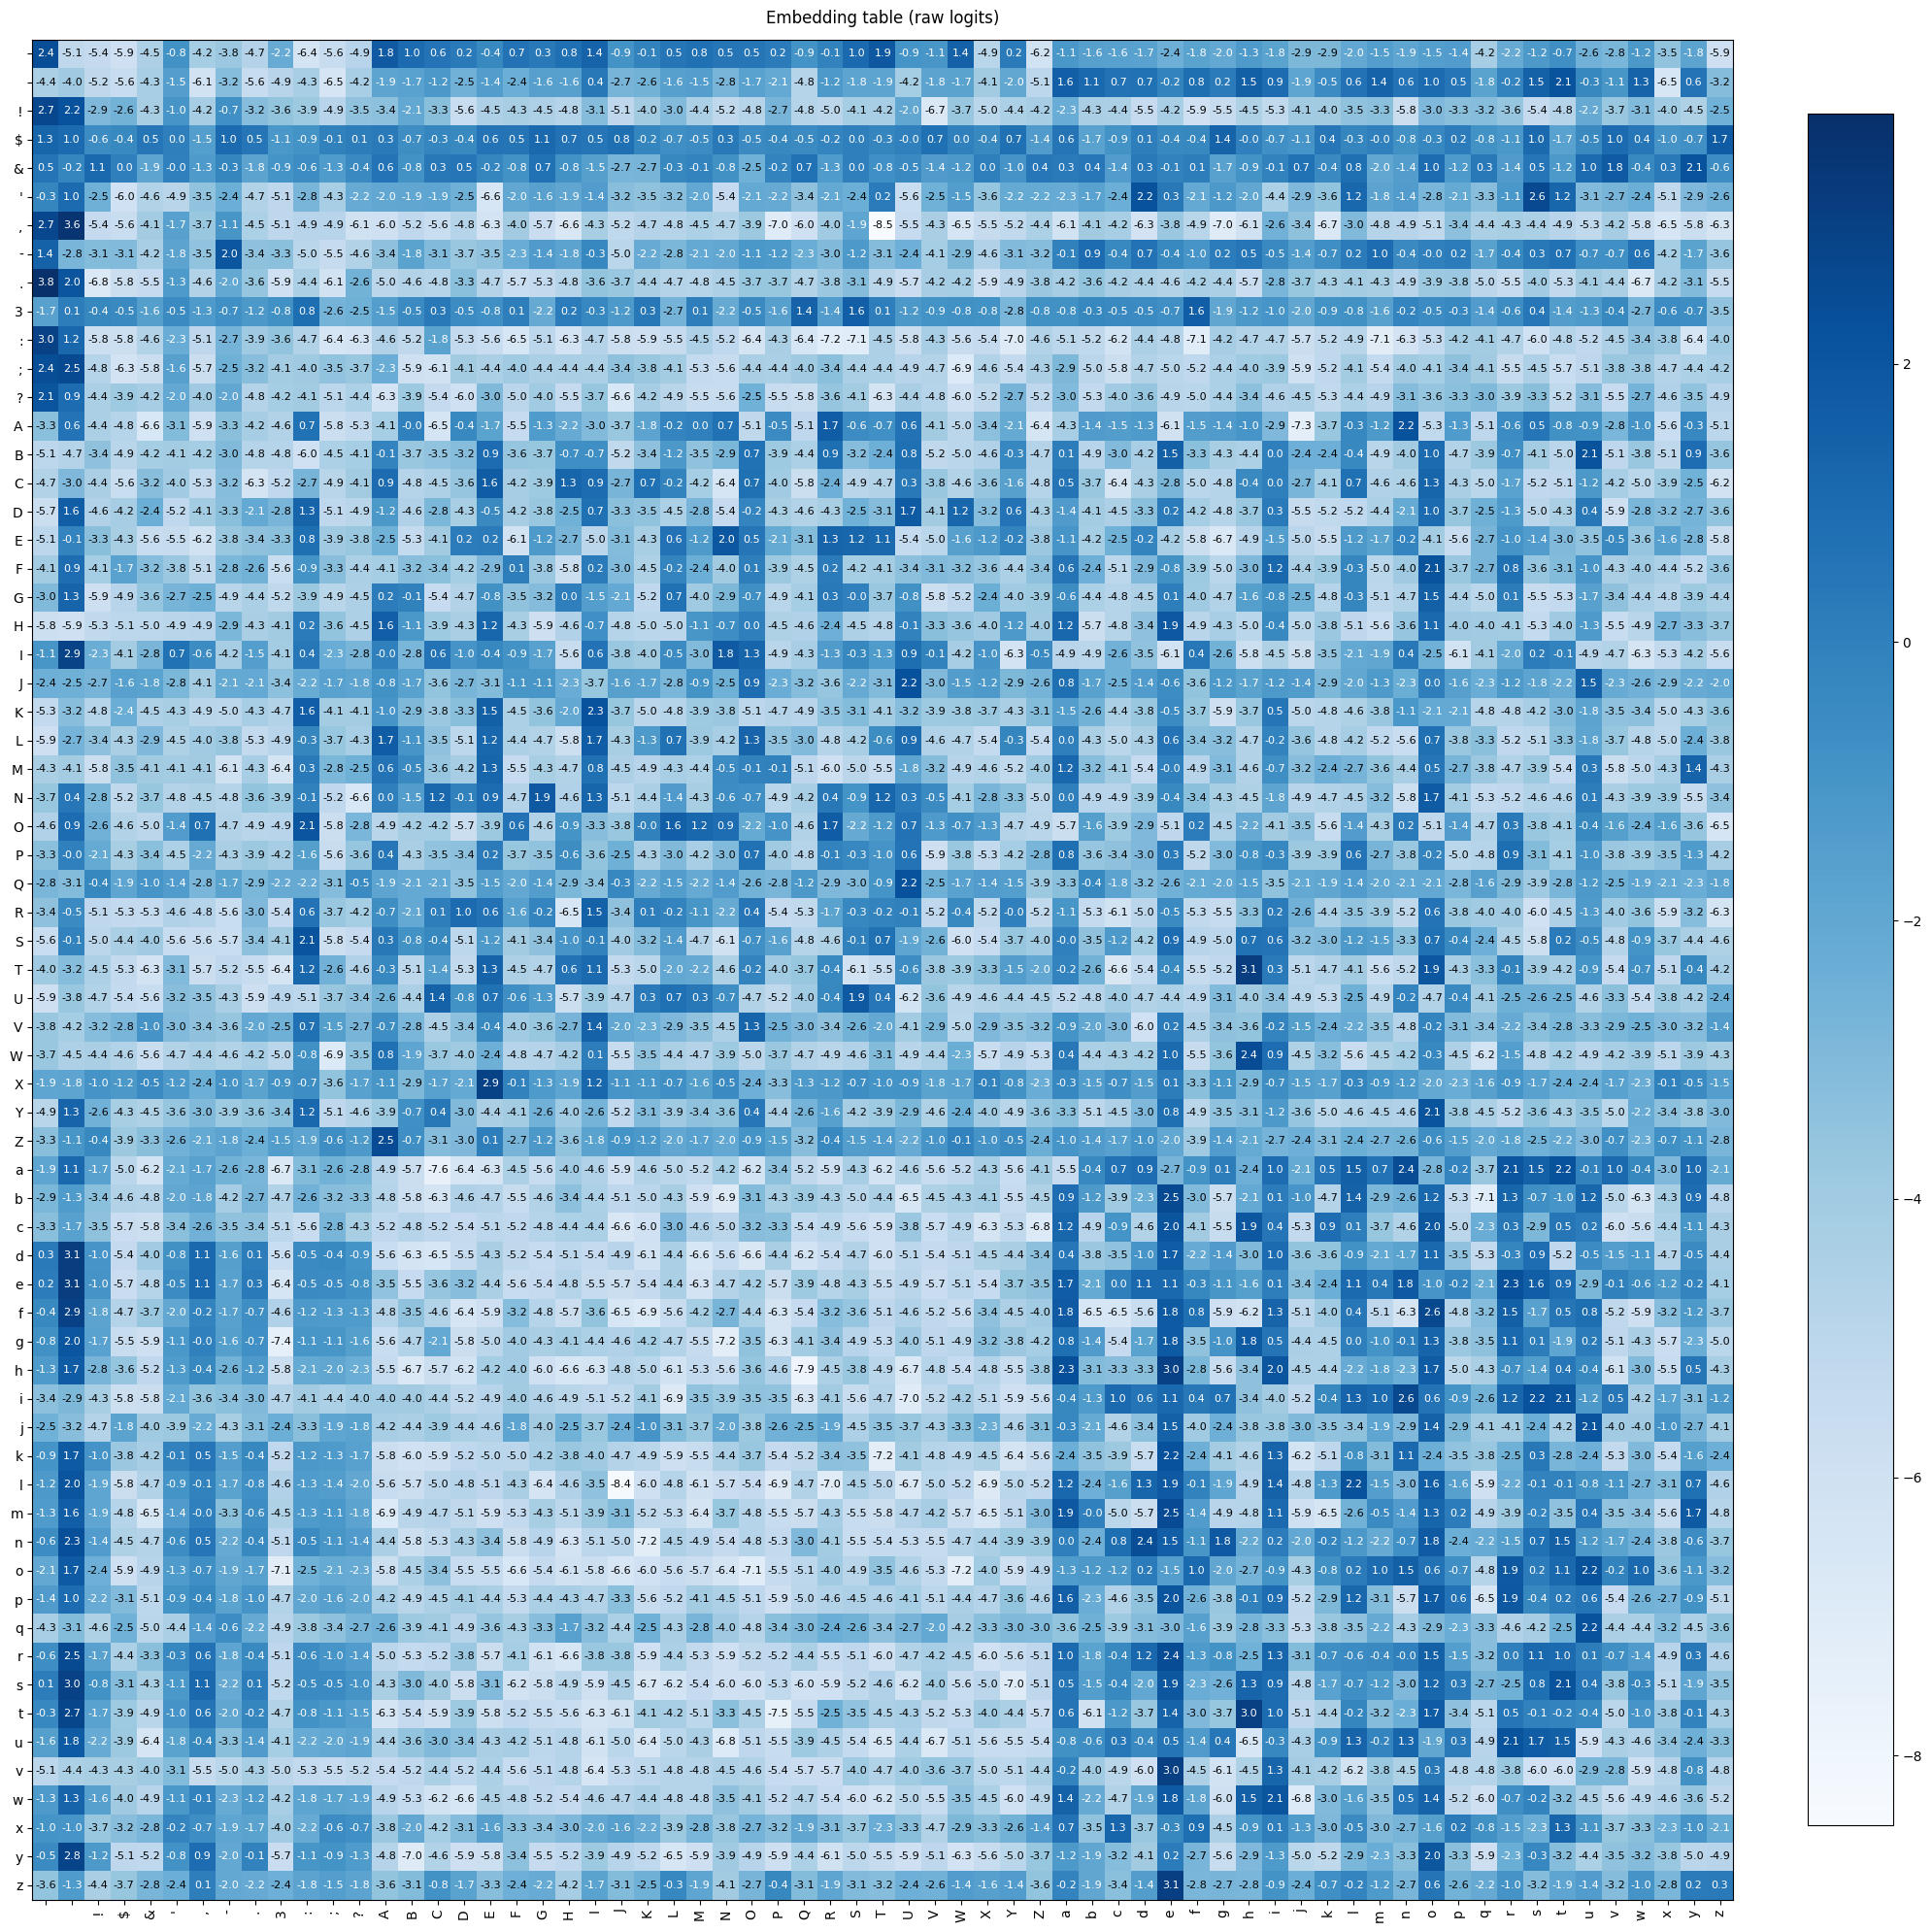

In [43]:
import torch
import matplotlib.pyplot as plt
import pandas as pd

def plot_embedding_table(model, itos, show_probs=False, annotate_if_small=True, cmap='Blues'):
    """
    model: your BigramLanguageModel instance (with .token_embedding_table)
    itos: list/tuple that maps index -> token string (len == vocab_size)
    show_probs: False -> show raw logits; True -> show row-wise softmax probabilities
    annotate_if_small: add text only when vocab_size <= 40
    cmap: matplotlib colormap for imshow
    """
    with torch.no_grad():
        W = model.token_embedding_table.weight.detach().cpu()  # (V, V)

        if show_probs:
            M = torch.softmax(W, dim=1)  # probabilities of next token given current token
            title = "Embedding table (row-softmax probabilities)"
        else:
            M = W
            title = "Embedding table (raw logits)"

        V = M.shape[0]
        fig = plt.figure(figsize=(min(20, 0.5*V + 4), min(20, 0.5*V + 4)))
        plt.imshow(M, cmap=cmap, aspect='auto')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.title(title, pad=12)

        # axes ticks with tokens
        plt.xticks(range(V), itos, rotation=90)
        plt.yticks(range(V), itos)

        # optional annotations (kept readable for small vocabularies)
        if annotate_if_small and V <= 80:
            # pick text color based on background intensity
            mat = M.numpy()
            vmin, vmax = float(mat.min()), float(mat.max())
            thresh = (vmin + vmax) / 2.0
            for i in range(V):
                for j in range(V):
                    val = mat[i, j]
                    txt = f"{val:.2f}" if show_probs else f"{val:.1f}"
                    color = "white" if val > thresh else "black"
                    plt.text(j, i, txt, ha='center', va='center', color=color, fontsize=8)

        plt.tight_layout()
        plt.show()

        df = pd.DataFrame(M.numpy(), index=itos, columns=itos)
        return df


df_logits = plot_embedding_table(m, stoi, show_probs=False)     # raw weights


```python
self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
```

- Creates an **embedding layer** that maps each input character (represented as an index) to a vector of size equal to the vocabulary.
- In this model, the embedding size is the same as the vocabulary size — so each character maps directly to a prediction over all possible next characters.

---

### 📦 Forward Method

```python
logits = self.token_embedding_table(idx)
```

- `idx` is a tensor of shape **(B, T)**:
  - **B** = Batch size (how many sequences processed in parallel)
  - **T** = Time steps (length of each sequence)
- The output `logits` has shape **(B, T, C)**, where:
  - **C** = Vocabulary size (number of possible characters)

---

### 🔁 Reshaping for Loss Calculation

```python
logits = logits.view(B*T, C)
targets = targets.view(B*T)
```

- The model output and target are reshaped into 2D tensors so we can apply a loss function across all predictions at once.

---

### 📉 Loss Computation

```python
loss = F.cross_entropy(logits, targets)
```

- Calculates how well the model's predictions match the actual next characters.
- This loss is used during training to adjust the model's weights and improve performance.

---

### 🧾 Output

The model returns:
- `logits`: the raw predictions for each character position
- `loss`: the training loss used to update the model

---

### In Simple Terms

This model learns **which character is likely to come next**, using just the current one. Over time, by minimizing the loss, it improves its predictions based on patterns in the training data.


In [17]:
print("loss : " ,loss)
import math
print(-(math.log(1/vocab_size)))

loss :  tensor(4.8786, grad_fn=<NllLossBackward0>)
4.174387269895637


## Comparing Model Loss to Uniform Distribution

- The current **model loss** is **4.87**.
- The expected loss from a **uniform distribution** (i.e., random guessing) is:

  $$
  -\log\left(\frac{1}{\text{vocab\_size}}\right) = 4.17
  $$

- Since **4.87 > 4.17**, the model is performing **worse than random guessing**, indicating it hasn't learned meaningful patterns yet.


In [26]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


## Text Generation Function (`generate`) — Brief Explanation

This function generates new text by extending an input sequence of token indices.

---

### Purpose

- Takes a current input tensor `idx` of shape **(B, T)** (batch size × time steps).
- Iteratively **predicts and appends** the next token for a total of `max_new_tokens` steps.
- Returns an extended sequence of shape **(B, T + max_new_tokens)**.

---

### Step-by-Step Overview

1. **Loop for Each New Token**:
   - Repeatedly calls the model on the current `idx` to get predictions (logits).
   - Ignores `loss` since no targets are provided.

2. **Focus on the Last Time Step**:
   - From logits of shape **(B, T, C)**, select only the last time step:
     $$
     \text{logits} = \text{logits}[:, -1, :] \quad \text{shape: } (B, C)
     $$

3. **Convert Logits to Probabilities**:
   $$
   \text{probs} = \text{softmax}(\text{logits})
   $$

4. **Sample the Next Token**:
   - Uses `torch.multinomial` to randomly sample the next token from the predicted distribution.

5. **Append to Sequence**:
   - The sampled token is concatenated to the existing sequence:
     $$
     \text{idx} = \text{concat}(idx, \text{idx\_next}) \quad \text{along time axis}
     $$

---


In [27]:

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


###  Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3

### the predicted is scrap because this is totally random model we need to train the model


In [35]:
optimizer = torch.optim.AdamW(m.parameters(), lr = 1e-3)


In [31]:
batch_size = 32
for steps in range(10000): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())


2.4522743225097656


In [33]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=600)[0].tolist()))



Awiuandac! thaforo nont
SLO:
Ange ive nn I ou m,
UCENTheanp'Lbet bazzl
TEEXNore t b'Thathon:
sous min'd ne st wousis s lingilo whee,
K:
Toow'e's,
D:
NGLEng, do te! ase may sin ceecate.
God? d
Aw ht hongur vet ouley, tonches s ousour mes o be angaxHatiminthafe atnt ur whis heand ay out sitourdy spehacugnting akefo tofed werore mo d htreldeg ise se inon ime weagsone the kener bs s oweclishentens t fougedsthouge t blrd moid y scad apapry ty an,
VII:
ABk onendas hthhave d irifThe myero mpthe aininis t, uthteawind ly fr bu$Howe t
ICEn thy theDWI' alit cofait? 'Becorpllim heouron, tos, thedeeno; me


## Limitations of the Bigram Model

Since this is a **bigram model**, it can only learn relationships between **one character and the next** — it doesn't use any longer context.

After training for **10,000 iterations**, the loss reduced to **2.45**, which shows some learning. However, the model is still limited because it cannot capture complex patterns in language.

To improve performance, we need to build a **more complex neural network** that can use **longer context** and understand deeper relationships in the text.